# Setup

In [ ]:
!pip install yfinance > log.txt
!pip install PyPortfolioOpt > log.txt
!pip install ffn > log.txt

# Download historical data

[How to use yfinance?](https://pypi.org/project/yfinance/)

In [1]:
import time
import yfinance as yf

symbols = ['^TWII', 'TLT', '^IXIC', 'BTC-USD', 'ETH-USD']

# create a empty dict to store data, than we could use this dict in pd.DataFrame()
ohlcvs = {}
for s in symbols:
  stock = yf.Ticker(s)
  df = stock.history(period="max")
  # data format change
  df.index= df.index.tz_localize(None)
  ohlcvs[s]=df
  #Avoid being treated as a malicious crawler
  time.sleep(1)

<Axes: xlabel='Date'>

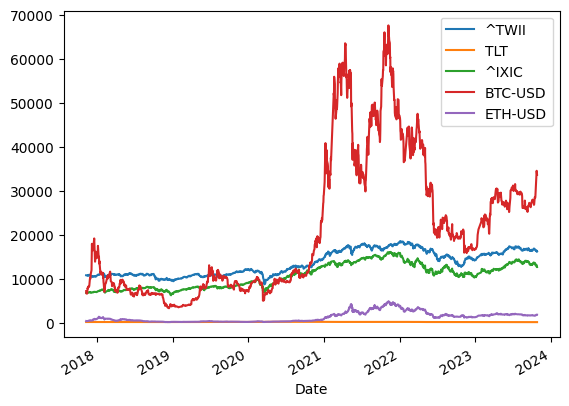

In [2]:
import pandas as pd
price = pd.DataFrame({s: ohlcvs[s].Close for s in symbols})
price = price.dropna(how='any')
price.plot()

# Weight asset example

[How to use pypfopt?](https://pyportfolioopt.readthedocs.io/en/latest/)

[pandas covariance(cov) api reference ](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html)

In [3]:
from pypfopt.hierarchical_portfolio import HRPOpt

# Diff:parameters name are differant from vedio.Does not affect.
# get daily rate of return
ret = price.pct_change()

#Finally,we use "None" at the end of the video, not ret(historical price),because is crude to approximate the future rate of return with the past rate of return.
portopt = HRPOpt(None, ret.cov())
weights = portopt.optimize()
weights

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.85118554 0.85118554]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


OrderedDict([('BTC-USD', 0.00859355643231502),
             ('ETH-USD', 0.005335188306308932),
             ('TLT', 0.43233603229718404),
             ('^IXIC', 0.13488571813229697),
             ('^TWII', 0.41884950483189504)])

# Backtesting

[ffn rebase api reference](https://pmorissette.github.io/ffn/)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.35018411 0.35018411]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1
/var/folders/vt/ljt3z28s6w5323hwjrv1_85m0000gn/T/ipykernel_66149/53081755.py:40: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  eqs = pd.concat([eqs, eq])
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.64091558 0.64091558]' h

,^TWII,TLT,^IXIC,BTC-USD,ETH-USD
2017-12-08,0.293567,0.300755,0.306413,0.043771,0.055495
2018-01-09,0.325171,0.315745,0.307069,0.032142,0.019873
2018-02-07,0.305912,0.378268,0.263454,0.028144,0.024222
2018-03-16,0.296887,0.369014,0.269282,0.024387,0.040430
2018-04-19,0.344535,0.367302,0.214480,0.044235,0.029449
...,...,...,...,...,...
2023-05-24,0.386755,0.336323,0.197836,0.044992,0.034094
2023-06-27,0.335451,0.351775,0.235979,0.035126,0.041669
2023-07-26,0.354571,0.215276,0.231028,0.136405,0.062720
2023-08-24,0.317342,0.277004,0.218504,0.092356,0.094794


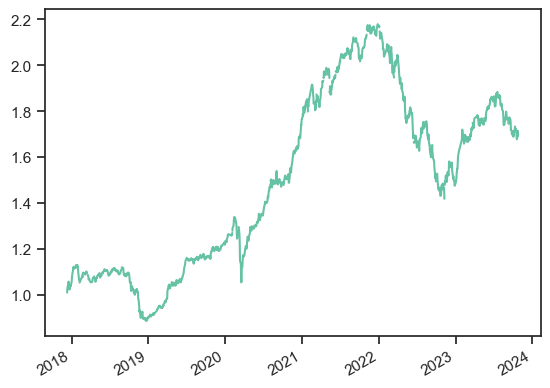

In [5]:
import ffn
import pypfopt

ndays = 20
# generate rebalance date
dates = price.index[::ndays]

# create empty series to store eq
eqs = pd.Series()
selected_symbols = ['^TWII', 'TLT', '^IXIC', 'BTC-USD', 'ETH-USD']

# equal_weight = pd.Series(1/len(selected_symbols), index=selected_symbols)

# create empty data dataframe to store weight
weight_history = pd.DataFrame(columns=selected_symbols)

# Diff:parameters name are differant from vedio.Does not affect.
# use zip to generate date pairs
# sdate~edate :Data period to adjust weight
# edate~fdate :Data period to backtest return
for sdate, edate, fdate in zip(dates, dates[1:], dates[2:]):

  # get data in sdate~edate to adjust weight
  historical_price = price.loc[sdate:edate][selected_symbols]
  # print(sdate, edate, fdate)

  # use pypfopt.risk_models.risk_matrix to optimize, ledoit_wolf is algorithm.
  cov = pypfopt.risk_models.risk_matrix(historical_price, method='ledoit_wolf')

  # Finally,we use "None" at the end of the video, not historical price,because is crude to approximate the future rate of return with the past rate of return.
  portopt = HRPOpt(None, cov)
  weights = portopt.optimize()

  # store weights in weight_history(empty data dataframe).
  weight_history.loc[edate] = pd.Series(weights)

  # Calculate the rate of return after adjusting the weight for each period.
  # use sum(axis=1),get he sum of each row.eq is value,that we store in eqs(empty series) to show return.
  eq = ((price.loc[edate:fdate][selected_symbols].rebase()  * weights).sum(axis=1)).pct_change()
  eqs = pd.concat([eqs, eq])

s = (eqs+1).cumprod()
s.plot()

weight_history

## Max dropdown

[cummax api reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cummax.html)

<Axes: >

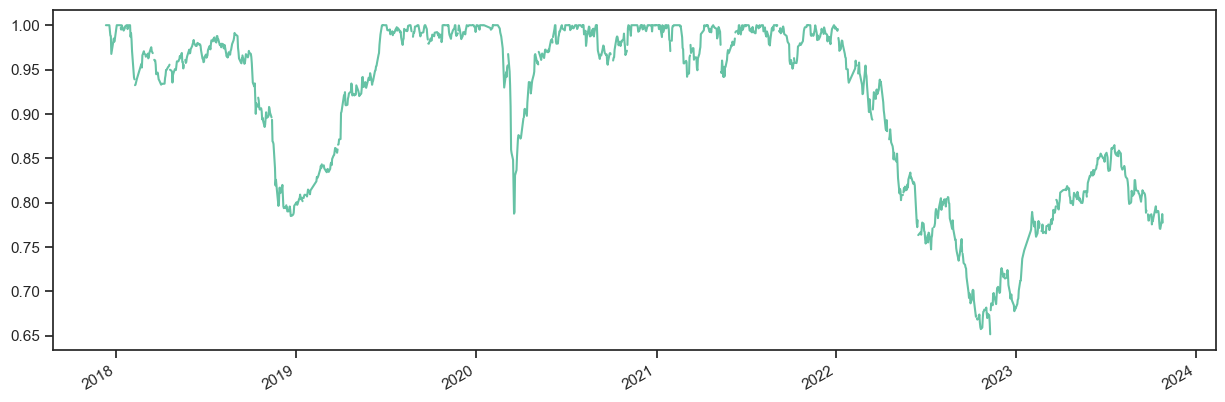

In [6]:
(s / s.cummax()).plot(figsize=(15,5))

# Analysis

<Axes: >

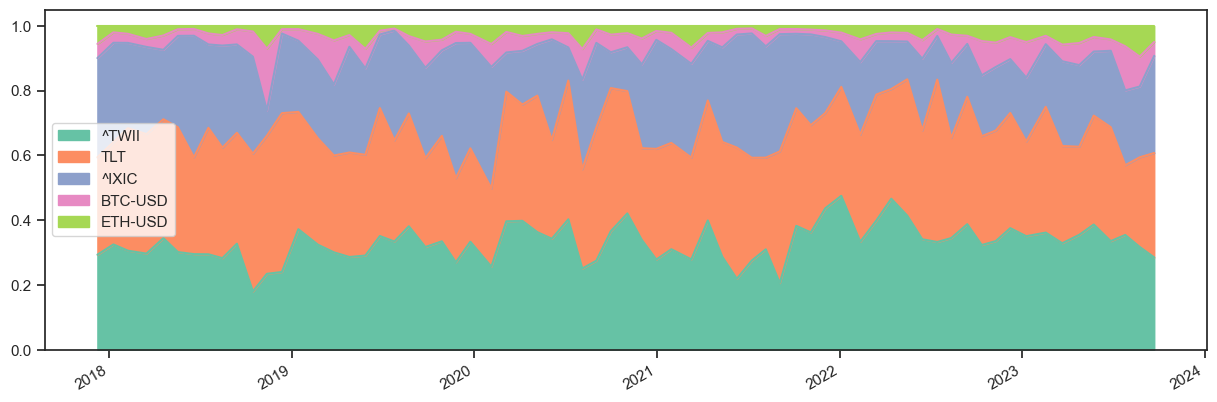

In [7]:
weight_history.plot.area(figsize=(15,5))

In [8]:
# ndays:example recent 20 days
historical_price = price.iloc[-ndays:]
cov = pypfopt.risk_models.risk_matrix(historical_price, method='ledoit_wolf')
portopt = HRPOpt(None, cov)
weights = portopt.optimize()
weights

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/pypfopt/hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.46202717 0.46202717]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  w[first_cluster] *= alpha  # weight 1


OrderedDict([('BTC-USD', 0.11816790704206193),
             ('ETH-USD', 0.11687122127718964),
             ('TLT', 0.1865593047067388),
             ('^IXIC', 0.23454230401995388),
             ('^TWII', 0.3438592629540558)])